# Quantify nutrient loading inputs
`create_scenario_pnt_wq_v3_090622.py` is "Python script for creating the river and point source scenario loading `ssm_pnt_wq.dat` input files"

In [1]:
import sys
import os
import yaml
import numpy as np
#import pandas
from io import StringIO
import pandas as pd
import pathlib
import time
from datetime import date
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl

### Define file paths

In [44]:
# Get paths from configuration file
case = 'whidbeypers'
with open(f'../../etc/SSM_config_{case}.yaml', 'r') as file:
    ssm = yaml.safe_load(file)
# loading_dir = pathlib.Path("/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/SalishSeaModel/run_scenarios/input_setting")
runs = [*ssm['paths']['nutrient_loading_inputs']]
loading_files = {}
for run in runs:
    print(ssm['paths']['nutrient_loading_inputs'][run])#loading_files[run] = loading_dir/f"ssm_pnt_wq_{run}.dat"

/mmfs1/gscratch/ssmc/USRS/PSI/Sukyong/kingcounty/WQM/WQM/hotstart/inputs/ssm_pnt_wq.dat
/mmfs1/gscratch/ssmc/USRS/PSI/Sukyong/kingcounty/WQM_REF/WQM_REF/hotstart/inputs/ssm_pnt_wq.dat
/mmfs1/gscratch/ssmc/USRS/PSI/Sukyong/kingcounty/3c/inputs/ssm_pnt_wq.dat
/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/SalishSeaModel/3l/hotstart/inputs/ssm_pnt_wq.dat
/mmfs1/gscratch/ssmc/USRS/PSI/Sukyong/kingcounty/3m/inputs/ssm_pnt_wq.dat
/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/SalishSeaModel/3n/hotstart/inputs/ssm_pnt_wq.dat
/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/SalishSeaModel/3o/hotstart/inputs/ssm_pnt_wq.dat


In [45]:
runs = [*ssm['paths']['nutrient_loading_inputs']]
runs

['wqm_baseline', 'wqm_reference', '3c', '3l', '3m', '3n', '3o']

In [46]:
# # directory for Su Kyong's runs
# root_output = '/mmfs1/gscratch/ssmc/USRS/PSI/Sukyong/kingcounty/'

# # directory for Rachael's runs
# root_output_rdm = (
#     "/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/SalishSeaModel/"
# )

# ssm['paths']['nutrient_loading_inputs']={
#     'wqm_baseline':root_output+'WQM/WQM/hotstart/inputs/ssm_pnt_wq.dat',
#     'wqm_reference':root_output+'WQM_REF/WQM_REF/hotstart/inputs/ssm_pnt_wq.dat',
#     '3l':root_output_rdm+'3l/hotstart/inputs/ssm_pnt_wq.dat',
#     '3m':root_output+'3m/inputs/ssm_pnt_wq.dat',
#     '3n':root_output_rdm+'3n/coldstart/inputs/ssm_pnt_wq.dat',
#     '3o':root_output_rdm+'3o/coldstart/inputs/ssm_pnt_wq.dat',
# }

### Create list of source names

In [47]:
in_dir = pathlib.Path('/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/spreadsheets')
source_locations = pd.read_excel(in_dir/'ssm_pnt_wq_station_info.xlsx',index_col='Unnamed: 0')
source_names=source_locations.index.tolist()

### Load loading inputs
This code comes from Ben Roberts.  I got the same results with my method but like Ben's better because it covers all variables. See [ssm_read_pnt_wq.ipynb](https://github.com/bedaro/ssm-analysis/blob/main/input_files/ssm_read_pnt_wq.ipynb)

From Ben Roberts:
```
The discharges are in m3/s, and cover a 24-hour period (technically the model linearly interpolates between them but that doesn't change the final result). The units for most constituents are mg/l and for the nitrogen constituents it's mg-N/l == g-N/m^3.

So when I load the NetCDF into a dataset named 'ds' and do this:
(ds['discharge'][:,0] * (ds['nh4'][:,0] + ds['no32'][:,0]) * 24 * 3600).sum()
```

In [48]:
inputs = {}
for run in runs:
    with open(ssm['paths']['nutrient_loading_inputs'][run]) as f:
        # The parsing logic here is is derived from the linkage instructions for the
        # model and direct examination of the source code

        # The first line does not contain important information and is treated only like
        # a filetype magic
        next(f)

        # The total number of discharge nodes
        num_qs = int(next(f))
        # All the node numbers with discharges
        #nodes = np.loadtxt([next(f) for l in range(num_qs)], comments='!', dtype=int)
        node_raw = StringIO('\n'.join([next(f) for l in range(num_qs)]))
        node_df = pd.read_csv(node_raw, sep='\s+!\s+', names=('Node','Comment'),
                              dtype={'Node':np.int64,'Comment':object}, engine='python')
        node_df.set_index('Node', inplace=True)
        nodes = node_df.index.to_numpy()
        # Depth distribution fractions into each node. Skipping the first (node count) column
        vqdist = np.loadtxt([next(f) for l in range(num_qs)])[:,1:]

        num_times = int(next(f))

        # Initialize storage arrays
        times = np.zeros(num_times)
        qs = np.zeros((num_times, num_qs))
        # State variables in the order they are present in the file. These are also going
        # to be the NetCDF variable names
        statevars = ('discharge', 'temp', 'salt', 'tss',  'alg1', 'alg2', 'alg3', 'zoo1',
                                  'zoo2', 'ldoc', 'rdoc', 'lpoc', 'rpoc', 'nh4',  'no32',
                                  'urea', 'ldon', 'rdon', 'lpon', 'rpon', 'po4',  'ldop',
                                  'rdop', 'lpop', 'rpop', 'pip',  'cod',  'doxg', 'psi',
                                  'dsi',  'alg1p','alg2p','alg3p','dic',  'talk')
        inputs[run] = {}
        for v in statevars:
            inputs[run][v] = np.zeros((num_times, num_qs))

        for t in range(num_times):
            times[t] = float(next(f))
            for v in statevars:
                inputs[run][v][t,:] = np.loadtxt([next(f)])

# Sum all loading over year  
Sum of loading over year for Agate East, node 15634, is 4926 kg/year

In [49]:
total_nitrogen={}
total_annual_nitrogen={}
loading={}
for run in runs:
    loading[run] = (inputs[run]['discharge'] * (inputs[run]['nh4'] + inputs[run]['no32']) * 24 * 3600)/1000 #m3/s*mg/l -> kg/day
    total_nitrogen[run]=loading[run].sum(axis=0) # annual loading over 366 days (g/year)
    total_annual_nitrogen[run] = total_nitrogen[run].sum() # g/year -> kg/year

In [50]:
total_annual_nitrogen

{'wqm_baseline': 51748970.95235588,
 'wqm_reference': 34182950.28326734,
 '3c': 45359842.21098727,
 '3l': 50739039.79951296,
 '3m': 58138095.43265276,
 '3n': 50456840.87141059,
 '3o': 51102889.800261796}

## Create dataframes to write to excel

In [51]:
total_nitrogen_df = pd.DataFrame(total_nitrogen, index=source_names) # scenario total
total_annual_nitrogen_df = pd.DataFrame(total_annual_nitrogen,index=['total loading']) # source total (by scenario)

In [52]:
total_annual_nitrogen_df

,wqm_baseline,wqm_reference,3c,3l,3m,3n,3o
total loading,5.174897e+07,3.418295e+07,4.535984e+07,5.073904e+07,5.813810e+07,5.045684e+07,5.110289e+07


In [53]:
total_nitrogen_df.head(3)

,wqm_baseline,wqm_reference,3c,3l,3m,3n,3o
Agate East,4925.721161,2076.954837,4925.721161,4925.721161,4925.721161,4925.721161,4925.721161
Agate West,936.577889,383.285032,936.577889,936.577889,936.577889,936.577889,936.577889
Anderson east,3446.356783,500.055386,3446.356783,3446.356783,3446.356783,3446.356783,3446.356783


# Create excel spreadsheet of total nitrogen loading per run

In [54]:
# make README 
this_file = '=HYPERLINK("https://github.com/UWModeling/SalishSeaModel-analysis/blob/main/notebooks/reports/QuantifyLoading.ipynb")'
run_description = '=HYPERLINK("https://github.com/RachaelDMueller/KingCounty-Rachael/blob/main/docs/supporting/KingCounty_Model_Runs.xlsx","KingCounty_Model_Runs.xlsx")'
units='kg/year'
created_by = 'Rachael D. Mueller'
created_at = 'Puget Sound Institute'
created_from = 'Model results produced by Su Kyong Yun (PNNL) and Rachael Mueller (PSI)'
created_on = date.today().strftime("%B %d, %Y")
contact = 'Rachael D Mueller (rdmseas@uw.edu)'
header = {
    ' ':[created_by, created_at, created_on, this_file, 
        contact, created_from, 
        run_description, units]
}
header_df = pd.DataFrame(header, index=[
    'Created by',
    'Created at',                           
    'Created on',
    'Created with',
    'Contacts',
    'Modeling by',
    'Model Run Overview',
    'Units'])

# Save to output to 
excel_output_path = pathlib.Path(ssm['paths']['processed_output'])/case/'spreadsheets'
with pd.ExcelWriter(excel_output_path/f'{case}_total_nitrogen_loading.xlsx', mode='w') as writer:
    total_annual_nitrogen_df.to_excel(writer, sheet_name='scenario_total')
    total_nitrogen_df.to_excel(writer, sheet_name='source_total')
    header_df.to_excel(writer, sheet_name='README')

([<matplotlib.axis.XTick at 0x15159e0a1ed0>,
 [Text(0, 0, '2014 Conditions'),
  Text(1, 0, 'Reference'),
  Text(2, 0, 'Wr1'),
  Text(3, 0, 'Wr2'),
  Text(4, 0, 'Wr3'),
  Text(5, 0, 'Wr4'),
  Text(6, 0, 'Wr5')])

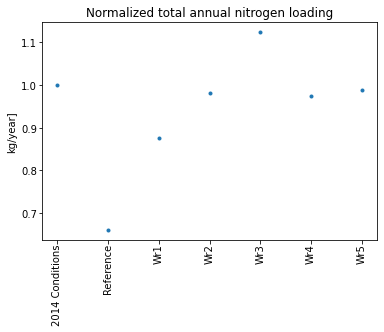

In [55]:
labels = [ssm['run_information']['run_tag'][case][key] for key in [*total_annual_nitrogen]]
# labels[0]='base'
# labels[1]='ref'
plt.plot([total_annual_nitrogen[key]/total_annual_nitrogen['wqm_baseline'] for key in [*total_annual_nitrogen]],'.')
plt.title('Normalized total annual nitrogen loading')
plt.ylabel('kg/year]')
plt.xticks(np.arange(0,len(labels)),labels,rotation=90)

In [56]:
total_annual_nitrogen

{'wqm_baseline': 51748970.95235588,
 'wqm_reference': 34182950.28326734,
 '3c': 45359842.21098727,
 '3l': 50739039.79951296,
 '3m': 58138095.43265276,
 '3n': 50456840.87141059,
 '3o': 51102889.800261796}

# Plot normalized loading values and regressions

In [57]:
river_runs = ssm['run_information']['whidbeypers_rivers']
#wwtp_runs = ssm['run_information']['whidbeypers_WWTPs']
#remove reference b/c we don't calculate volume days noncompliance for reference case
# river_runs.pop('wqm_reference')
# wwtp_runs.pop('wqm_reference')
# wwtp_runs.pop('Wtp7')

In [58]:
river_runs

{'wqm_baseline': '2014 conditions',
 'wqm_reference': 'Reference conditions',
 '3c': 'Wr1',
 '3l': 'Wr2',
 '3m': 'Wr3',
 '3n': 'Wr4',
 '3o': 'Wr5'}

## Create lists of runs for coloring plot markers

In [59]:
runs_renamed={}
runs_renamed['rivers']=[ssm['run_information']['run_tag'][case][key] for key in [*river_runs]]
runs_renamed['base']=['2014 Conditions']
# Wtp7 needs to be re-done.   Removing from graphic
runs_renamed['rivers'].remove('Reference')
runs_renamed['rivers']

['2014 Conditions', 'Wr1', 'Wr2', 'Wr3', 'Wr4', 'Wr5']

## Create normalized volume days values

In [83]:
region = 'ALL_REGIONS' # 'Whidbey' # 

nc_input = pd.read_excel(f'/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/data/{case}/spreadsheets/{case}_wc_noncompliant_m0p25.xlsx',
                           sheet_name='Volume_Days',
                          index_col="Unnamed: 0")

vol_day_norm={}
for run in [*nc_input]:
    vol_day_norm[run] = nc_input[run][region]/nc_input['2014 Conditions'][region]
vol_day_norm

{'2014 Conditions': 1.0,
 'Wr1': 0.028883478058174487,
 'Wr2': 0.7852548079536077,
 'Wr3': 5.149649311438766,
 'Wr4': 0.022534141673607833,
 'Wr5': 0.028505346777720247}

## Create normalized loading values

In [84]:
[*total_annual_nitrogen]

['wqm_baseline', 'wqm_reference', '3c', '3l', '3m', '3n', '3o']

In [85]:
normalized_loading = {}
for run in [*total_annual_nitrogen]:
    # use mapping from Hyak to report names (ssm['run_information']['run_tag']['whidbey']) 
    # to get key-values with report names
    print(ssm['run_information']['run_tag'][case][run])
    normalized_loading[ssm['run_information']['run_tag'][case][run]] = total_annual_nitrogen[run]/total_annual_nitrogen['wqm_baseline'] 
normalized_loading


2014 Conditions
Reference
Wr1
Wr2
Wr3
Wr4
Wr5


{'2014 Conditions': 1.0,
 'Reference': 0.6605532371791281,
 'Wr1': 0.8765361199694012,
 'Wr2': 0.9804840340927217,
 'Wr3': 1.123463797689411,
 'Wr4': 0.9750308062717823,
 'Wr5': 0.9875150917940202}

In [86]:
N_plot={}
vd_plot={}
for group in ['rivers','base']:
    N_plot[group] = np.array([normalized_loading[run] for run in runs_renamed[group]])
    vd_plot[group] = np.array([vol_day_norm[run] for run in runs_renamed[group]])

In [87]:
N_plot['rivers']

array([1.        , 0.87653612, 0.98048403, 1.1234638 , 0.97503081,
       0.98751509])

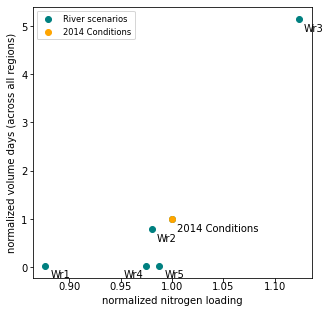

In [88]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5),
       gridspec_kw={
           'width_ratios': [1],
           'height_ratios': [1],
       'wspace': 0.25,
       'hspace': 0.15})
ax.scatter(N_plot['rivers'],vd_plot['rivers'],color='teal',label='River scenarios')
ax.scatter(N_plot['base'],vd_plot['base'],color='orange',label='2014 Conditions')
# add run labels to graphic
[ax.text(x=N_plot['rivers'][idx]+.005, y=vd_plot['rivers'][idx]-.25, s=run_name) for idx,run_name in enumerate(['2014 Conditions', 'Wr1', 'Wr2', 'Wr3'])]
ax.text(x=N_plot['rivers'][5]-.035, y=vd_plot['rivers'][5]-.25, s='Wr4')
ax.text(x=N_plot['rivers'][5]+.005, y=vd_plot['rivers'][5]-.25, s='Wr5')

# plt.plot(np.unique(N_plot[rivers_2014]), np.poly1d(np.polyfit(N_plot[rivers_2014], vd_plot[rivers_2014], 1))(np.unique(N_plot[rivers_2014])), color='teal')
# plt.plot(np.unique(N_plot[wwtp_2014]), np.poly1d(np.polyfit(N_plot[wwtp_2014], vd_plot[wwtp_2014], 1))(np.unique(N_plot[wwtp_2014])), color='purple')
# x = np.array([.9,1,1.1])
#plt.plot(x, 14.06516795*x + -13.07638237,'k')
# fig.text(.15,0.825,f"y={w_poly['rivers'][1]:2.1f}x+{w_poly['rivers'][0]:2.1f} (RMSE: {rmse['rivers']:.2f})",color='teal')
# fig.text(.15,0.775,f"y={w_poly['wwtp'][1]:2.1f}x+{w_poly['wwtp'][0]:2.1f} (RMSE: {rmse['wwtp']:.2f})",color='purple')
ax.legend(bbox_to_anchor=(0,1),loc='upper left')
ax.set_xlabel('normalized nitrogen loading')
if region == "ALL_REGIONS":
    ax.set_ylabel(f'normalized volume days (across all regions)')
else:
    ax.set_ylabel(f'normalized volume days ({region})')
plt.savefig(f'/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/graphics/line_fits/whidbeypers_nitrogen_volumedays_fit_{region}.png', bbox_inches='tight', format='png', dpi=1000)

## Calculate line fits and RMSE

In [21]:
w_poly={}
rmse={}
xvalues={}
yvalues={}

# fit_values = w_poly['rivers'][2]*N_plot[rivers_2014]**2+w_poly['rivers'][1]*N_plot[rivers_2014]+w_poly['rivers'][0]                                                          
# rmse['rivers']=np.sqrt(np.sum((vd_plot[rivers_2014]-fit_values)**2)/len(vd_plot[rivers_2014]))

# line for WWTPs
w_poly['wwtp']=np.poly1d(np.polyfit(N_plot['wwtp'], vd_plot['wwtp'], 1))
fit_values = w_poly['wwtp'][1]*N_plot['wwtp']+w_poly['wwtp'][0]                                                          
rmse['wwtp']=np.sqrt(np.sum((vd_plot['wwtp']-fit_values)**2)/len(vd_plot['wwtp']))
print('rmse wwtps: ', rmse['wwtp'])

# polynnomial for rivers
w_poly['rivers']=np.poly1d(np.polyfit(N_plot['rivers'], vd_plot['rivers'], 3))
fit_values = w_poly['rivers'][3]*N_plot['rivers']**3+w_poly['rivers'][2]*N_plot['rivers']**2+w_poly['rivers'][1]*N_plot['rivers']+w_poly['rivers'][0] 
rmse['rivers']=np.sqrt(np.sum((vd_plot['rivers']-fit_values)**2)/len(vd_plot['rivers']))
xvalues['rivers']=np.arange(N_plot['rivers'][0],N_plot['rivers'][-2]+.01, 0.01)
yvalues['rivers']=w_poly['rivers'][3]*xvalues['rivers']**3+w_poly['rivers'][2]*xvalues['rivers']**2+w_poly['rivers'][1]*xvalues['rivers']+w_poly['rivers'][0] 
print('rmse rivers: ', rmse['rivers'])

rmse wwtps:  0.016489417830139644
rmse rivers:  4.3161690267511403e-13
